In [1]:
%matplotlib inline
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
from matplotlib.ticker import StrMethodFormatter

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve, learning_curve

In [3]:
def plot_bin_scores(scores, ax):
    gb = scores.groupby(by="bin", as_index=False)
    scores_mean = gb.mean()["acc"]
    scores_std = gb.std()["acc"]
    num_bins = len(scores_mean)
    x = np.arange(num_bins)
    ax.plot(x, scores_mean)
    ax.fill_between(x, scores_mean - scores_std, 
                    scores_mean + scores_std, alpha=0.15)
    ax.set_xlabel('bin number')
    ax.set_ylabel('accuracy')
    ax.grid()
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
    return ax, scores_mean

In [4]:
def read_ve(ve_file):
    ve = pd.read_csv(ve_file, header=None).transpose()
    new_header = ve.iloc[0]
    ve = ve[1:]
    ve.columns = new_header
    # 'EOG002', 'EOG003',
    if ve_file.find('movcorr') != -1:
        ve = ve.drop(['EOG002', 'EOG003', 'STI016', 'STI101', 'STI102', 'SYS101', 'SYS201', 
                      'CHPI001', 'CHPI002', 'CHPI003', 'CHPI004', 'CHPI005',
                      'CHPI006', 'CHPI007', 'CHPI008', 'CHPI009'
                      ],
                     axis=1)
    else:
        ve = ve.drop(['EOG002', 'EOG003', 'STI016', 'STI101', 
                      'STI102', 'SYS101', 'SYS201'],
                     axis=1)        
    ve = ve.apply(pd.to_numeric, errors='ignore')    
    return ve

In [26]:
file0 = ve0_24_file[0]

In [30]:
bool(file0.find('movcorr'))

True

## Load p24

In [5]:
n_trials = 79 * 2
participant = 'p24_movcorr'
ve0_24_file = sorted(glob('data/visual/{}/VE0*'.format(participant)))
ve1_24_file = sorted(glob('data/visual/{}/VE1*'.format(participant)))

In [6]:
ve0_24 = pd.concat([read_ve(ve) for ve in ve0_24_file],
                   ignore_index=True)

ve1_24 = pd.concat([read_ve(ve) for ve in ve1_24_file],
                   ignore_index=True)

In [7]:
bins_per_trial = int(ve0_24.shape[0] / n_trials)
print(bins_per_trial)

100


In [8]:
# ve0.columns.get_loc("MEG1521")
X_0_24 = ve0_24.iloc[:, :].values
X_1_24 = ve1_24.iloc[:, :].values

In [9]:
X_0_24 = X_0_24.reshape(n_trials, bins_per_trial, -1)
X_1_24 = X_1_24.reshape(n_trials, bins_per_trial, -1)
# [trial_number, bin, sensor]
print(X_0_24.shape)
print(X_1_24.shape)

(158, 100, 315)
(158, 100, 315)


## Load p27

In [10]:
participant = 'p27_movcorr'
ve0_27_file = sorted(glob('data/visual/{}/VE0*'.format(participant)))
ve1_27_file = sorted(glob('data/visual/{}/VE1*'.format(participant)))

In [11]:
ve0_27 = pd.concat([read_ve(ve) for ve in ve0_27_file],
                ignore_index=True)
ve1_27 = pd.concat([read_ve(ve) for ve in ve1_27_file],
                ignore_index=True)

In [12]:
bins_per_trial = int(ve0_27.shape[0] / n_trials)
print(bins_per_trial)

100


In [13]:
X_0_27 = ve0_27.iloc[:, :].values
X_1_27 = ve1_27.iloc[:, :].values

In [14]:
X_0_27 = X_0_27.reshape(n_trials, bins_per_trial, -1)
X_1_27 = X_1_27.reshape(n_trials, bins_per_trial, -1)
# [trial_number, bin, sensor]
print(X_0_27.shape)
print(X_1_27.shape)

(158, 100, 315)
(158, 100, 315)


## Classify

In [15]:
pipeline = make_pipeline(MaxAbsScaler(),
                         # PCA(n_components=.99, svd_solver='full'),
                         LogisticRegression(C=1, 
                                            solver='liblinear', 
                                            penalty='l1')
                         )
cvss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
cvsk = StratifiedKFold(n_splits=10, random_state=42)

In [16]:
X_24 = np.concatenate((X_0_24, X_1_24))
X_27 = np.concatenate((X_0_27, X_1_27))
y_24 = np.repeat([1, -1], int(X_24.shape[0] / 2))
y_27 = np.repeat([1, -1], int(X_27.shape[0] / 2))

### 24 train, 27 predict

In [17]:
bin_scores = {}
# bins_per_trial = 0
for b in range(bins_per_trial):
    X_tr = X_24[:, b, :]
    X_te = X_27[:, b, :]
    y_tr = y_24
    y_te = y_27
    pipeline_fit = pipeline.fit(X_tr, y_tr)
    y_pred = pipeline_fit.predict(X_te)
    this_bin_scores = accuracy_score(y_te, y_pred)
#     this_bin_scores = cross_val_score(gscv, X, y, cv=10)
    bin_scores[b] = [this_bin_scores]

scores = pd.melt(pd.DataFrame(bin_scores), var_name="bin", value_name="acc")

sorted_scores = (scores
                 .groupby(by="bin", as_index=False)
                 .mean()
                 .sort_values(by='acc', ascending=False)
                 .head(10)
                )

In [18]:
sorted_scores

bin       acc
34   34  0.658228
36   36  0.620253
37   37  0.607595
12   12  0.604430
40   40  0.601266
3     3  0.585443
64   64  0.585443
78   78  0.579114
57   57  0.569620
77   77  0.569620

In [19]:
best_bin = sorted_scores.bin.iloc[0]

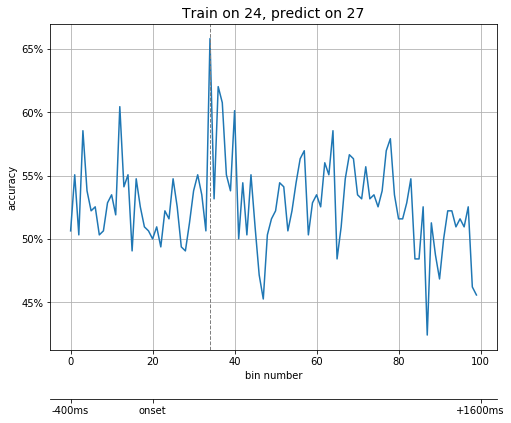

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
ax, score_means = plot_bin_scores(scores, ax)
ax.set_title('Visual - Train on 24, predict on 27',
             fontsize=14)
ax2 = ax.twiny()
ax2.plot(range(len(score_means)), score_means, alpha=0)
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.15))
# Turn on the frame for the twin axis, but then hide all 
# but the bottom spine
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
for sp in ax2.spines.values():
    sp.set_visible(False)
ax2.spines["bottom"].set_visible(True)
ax2.set_xticks([0, 20, 100])
ax2.set_xticklabels(["-400ms", "onset", "+1600ms"])
ax.axvline(best_bin, color='grey', ls='--', lw=1)

### 27 train, 24 predict

In [21]:
bin_scores = {}
# bins_per_trial = 0
for b in range(bins_per_trial):
    X_tr = X_27[:, b, :]
    X_te = X_24[:, b, :]
    y_tr = y_27
    y_te = y_24
    pipeline_fit = pipeline.fit(X_tr, y_tr)
    y_pred = pipeline_fit.predict(X_te)
    this_bin_scores = accuracy_score(y_te, y_pred)
#     this_bin_scores = cross_val_score(gscv, X, y, cv=10)
    bin_scores[b] = [this_bin_scores]

scores = pd.melt(pd.DataFrame(bin_scores), var_name="bin", value_name="acc")

sorted_scores = (scores
                 .groupby(by="bin", as_index=False)
                 .mean()
                 .sort_values(by='acc', ascending=False)
                 .head(10)
                )

In [22]:
sorted_scores

bin       acc
36   36  0.651899
4     4  0.601266
69   69  0.594937
23   23  0.588608
12   12  0.582278
34   34  0.582278
29   29  0.579114
37   37  0.575949
26   26  0.575949
91   91  0.572785

In [23]:
best_bin = sorted_scores.bin.iloc[0]

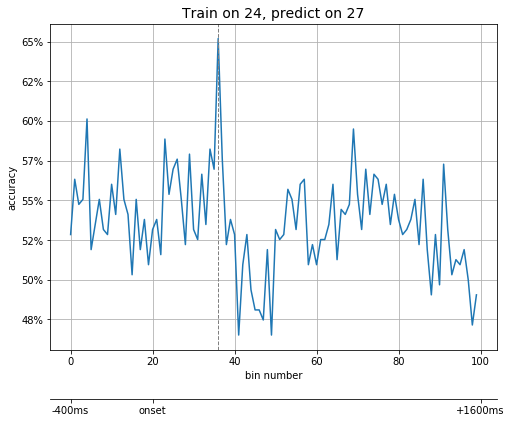

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
ax, score_means = plot_bin_scores(scores, ax)
ax.set_title('Visual - Train on 27, predict on 24',
             fontsize=14)
ax2 = ax.twiny()
ax2.plot(range(len(score_means)), score_means, alpha=0)
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.15))
# Turn on the frame for the twin axis, but then hide all 
# but the bottom spine
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
for sp in ax2.spines.values():
    sp.set_visible(False)
ax2.spines["bottom"].set_visible(True)
ax2.set_xticks([0, 20, 100])
ax2.set_xticklabels(["-400ms", "onset", "+1600ms"])
ax.axvline(best_bin, color='grey', ls='--', lw=1)